In [1]:
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import math
import xgboost as xgb
plt.rcParams['axes.unicode_minus'] = False

rc('font', family='AppleGothic')

In [288]:
train = pd.read_csv("./Kor_Train_교통사망사고정보(12.1~17.6).csv")
print(train.shape)
train.head()

(25037, 27)


,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,...,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도
0,2017,2017063023,14,야간,금,1,1,0,0,0,...,단일로,기타단일로,승용차,승용차,보행자,보행자,967633,1937456,127.134130,37.435704
1,2017,2017063021,45,야간,금,1,4,2,1,0,...,단일로,기타단일로,승용차,승용차,승용차,승용차,966456,1696405,127.131220,35.262534
2,2017,2017063021,50,야간,금,1,1,0,0,0,...,단일로,기타단일로,승용차,승용차,보행자,보행자,900057,1865697,126.379922,36.784142
3,2017,2017063019,10,야간,금,1,1,0,0,0,...,교차로,교차로부근,승용차,승용차,이륜차,이륜차,1095230,1764891,128.554945,35.875973
4,2017,2017063017,2,주간,금,1,2,1,0,0,...,단일로,교량위,이륜차,이륜차,화물차,화물차,947576,1946355,126.906786,37.514993


In [289]:
test = pd.read_csv("./test_kor.csv")
print(test.shape)
test.head()

(50, 16)


,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류
0,야간,금,NaN,NaN,0.0,NaN,0.0,경기,화성시,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차
1,야간,금,NaN,NaN,0.0,NaN,0.0,전남,영암군,차대사람,차도통행중,과속,단일로,기타단일로,승용차,보행자
2,야간,월,1.0,NaN,NaN,0.0,NaN,전남,곡성군,차량단독,전도전복,안전운전 의무 불이행,단일로,기타단일로,자전거,없음
3,야간,일,2.0,NaN,NaN,1.0,NaN,대구,달성군,차대차,측면충돌,중앙선 침범,단일로,기타단일로,승용차,승합차
4,주간,목,1.0,NaN,NaN,NaN,0.0,전남,고흥군,차대차,정면충돌,중앙선 침범,단일로,기타단일로,화물차,화물차


## fillin_사고유형_대분류

In [4]:
# feature columns : 당사종별_2당_대분류

In [5]:
train["당사자종별_2당_대분류_보행자"] = train["당사자종별_2당_대분류"] == "보행자"
train["당사자종별_2당_대분류_없음"] = train["당사자종별_2당_대분류"] == "없음"

test["당사자종별_2당_대분류_보행자"] = test["당사자종별_2당_대분류"] == "보행자"
test["당사자종별_2당_대분류_없음"] = test["당사자종별_2당_대분류"] == "없음"

In [6]:
feature_names = ["당사자종별_2당_대분류_보행자", "당사자종별_2당_대분류_없음"]
label_name = "사고유형_대분류"

In [7]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [8]:
model = xgb.XGBClassifier()

In [9]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [10]:
predictions = model.predict(X_test)
test["result_사고유형_대분류"] = predictions
test.loc[test["사고유형_대분류"].isnull(), "사고유형_대분류"] = test["result_사고유형_대분류"]

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## fillin_도로형태_대분류

### part1

In [11]:
# feature columns : 도로형태

In [12]:
train["도로형태_단일로"] = train["도로형태"].str.contains("단일로")
train["도로형태_교차로"] = train["도로형태"].str.contains("교차로")

test["도로형태_단일로"] = test["도로형태"].str.contains("단일로")
test["도로형태_교차로"] = test["도로형태"].str.contains("교차로")

In [13]:
train.loc[train["도로형태_단일로"].isnull(), "도로형태_단일로"] = False
train.loc[train["도로형태_교차로"].isnull(), "도로형태_교차로"] = False

test.loc[test["도로형태_단일로"].isnull(), "도로형태_단일로"] = False
test.loc[test["도로형태_교차로"].isnull(), "도로형태_교차로"] = False

In [14]:
feature_names = ["도로형태_단일로", "도로형태_교차로"]
label_name = "도로형태_대분류"

In [15]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [16]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [17]:
predictions = model.predict(X_test)
test["result_도로형태_대분류"] = predictions
test.loc[(test["도로형태_대분류"].isnull()) & (test["도로형태"].notnull()), "도로형태_대분류"] = test["result_도로형태_대분류"]

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### part2

In [18]:
# feature columns : 사고유형_중분류, 법규위반

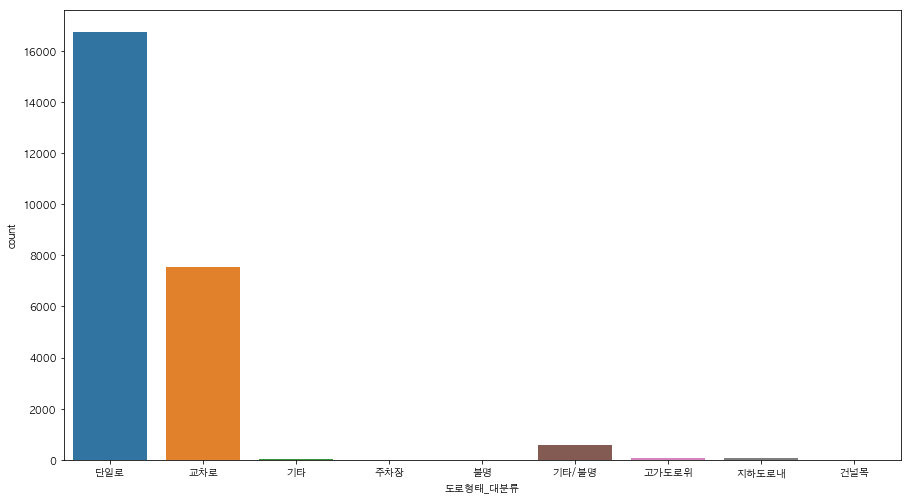

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8.27)  
sns.countplot(data=train, x="도로형태_대분류")

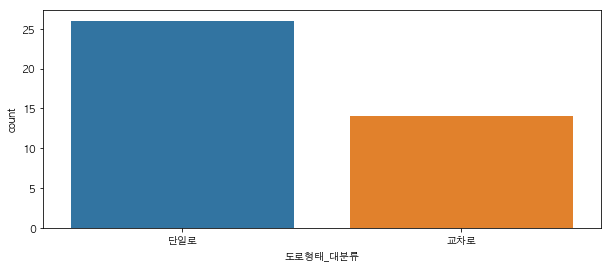

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)  
sns.countplot(data=test, x="도로형태_대분류")

In [21]:
train_단일로 = train.loc[train["도로형태_대분류"] == "단일로"]
train_교차로 = train.loc[train["도로형태_대분류"] == "교차로"]

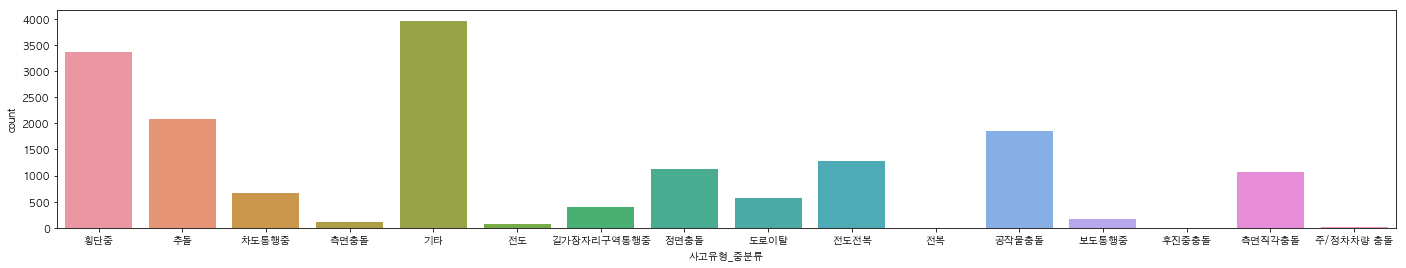

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 4)
sns.countplot(data=train_단일로, x="사고유형_중분류")

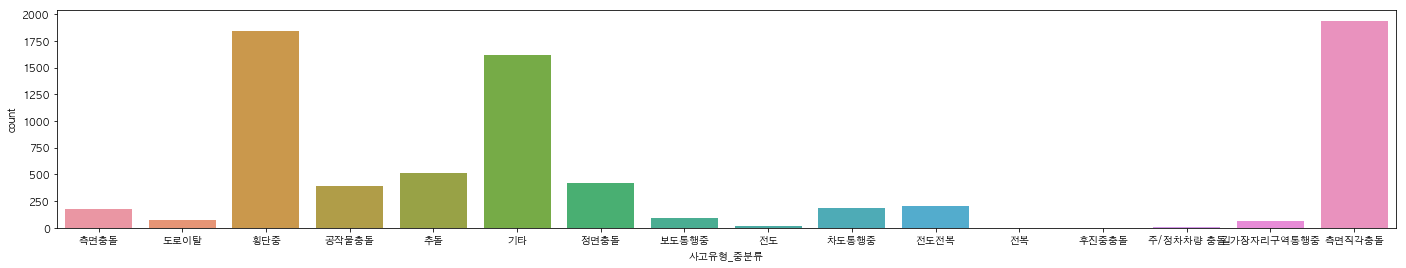

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 4)
sns.countplot(data=train_교차로, x="사고유형_중분류")

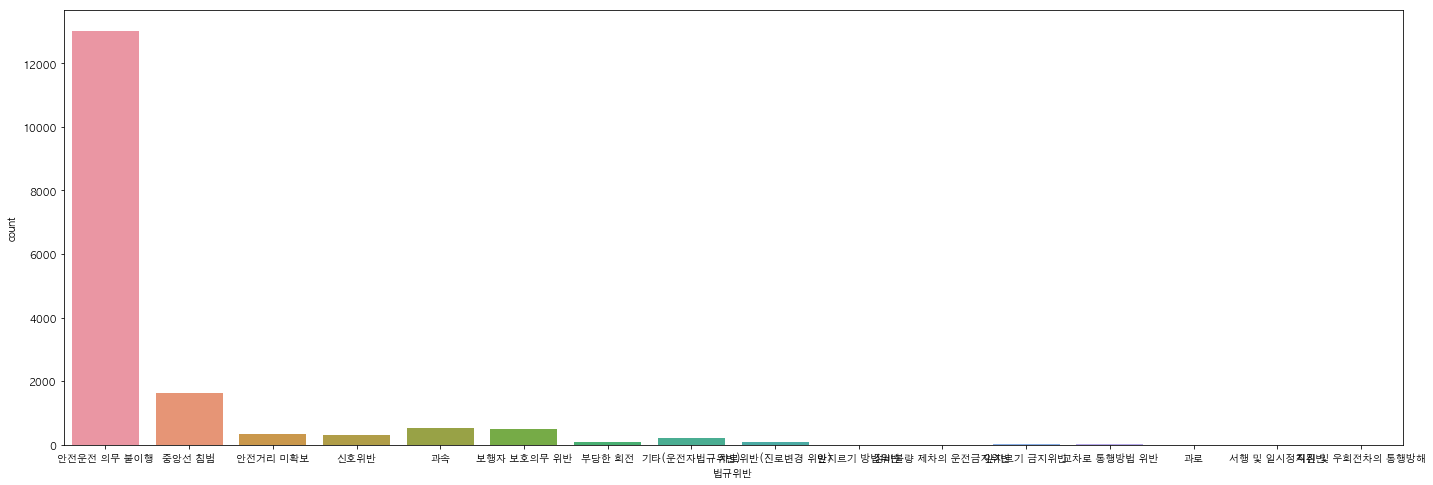

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 8)
sns.countplot(data=train_단일로, x="법규위반")

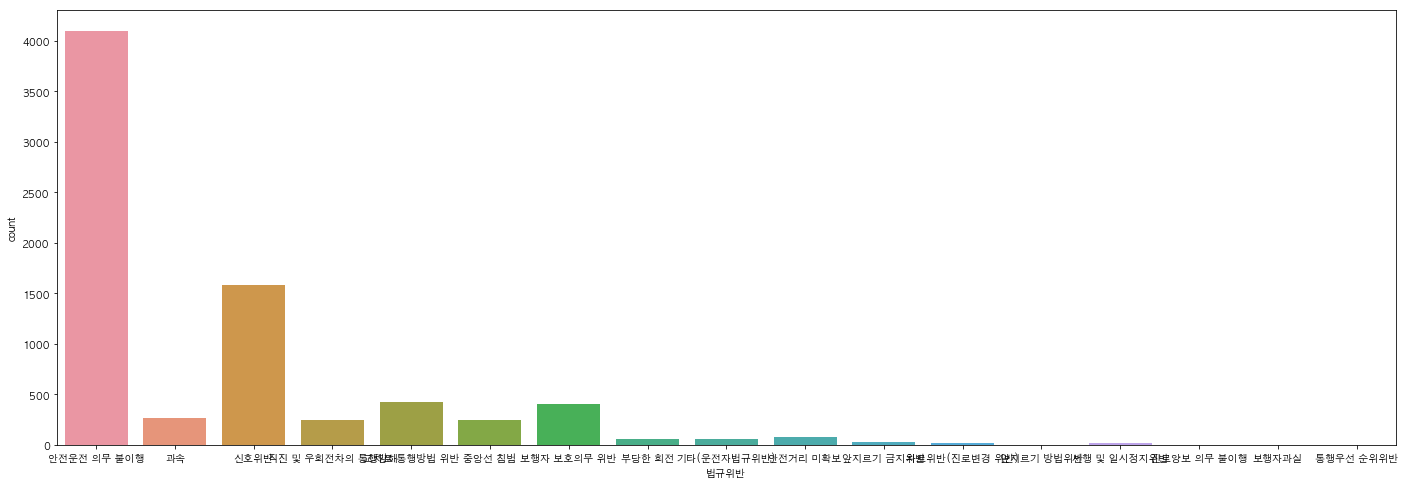

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 8)
sns.countplot(data=train_교차로, x="법규위반")

In [26]:
train["사고유형_중분류_측면충돌"] = train["사고유형_중분류"] == "측면충돌"

test["사고유형_중분류_측면충돌"] = test["사고유형_중분류"] == "측면충돌"

In [27]:
train["법규위반_신호위반"] = train["법규위반"] == "신호위반"

test["법규위반_신호위반"] = test["법규위반"] == "신호위반"

In [28]:
feature_names = ["사고유형_중분류_측면충돌", "법규위반_신호위반"]
label_name = "도로형태_대분류"

In [29]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [30]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
predictions = model.predict(X_test)
test["result_도로형태_대분류"] = predictions
test.loc[test["도로형태_대분류"].isnull(), "도로형태_대분류"] = test["result_도로형태_대분류"]

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## fillin_도로형태

In [32]:
# feature colums : 도로형태_대분류, 법규위반

In [33]:
train["도로형태_대분류_단일로"] = train["도로형태_대분류"] == "단일로"
train["도로형태_대분류_교차로"] = train["도로형태_대분류"] == "교차로"

test["도로형태_대분류_단일로"] = test["도로형태_대분류"] == "단일로"
test["도로형태_대분류_교차로"] = test["도로형태_대분류"] == "교차로"

In [34]:
train["법규위반_보행자 보호의무 위반"] = train["법규위반"] == "보행자 보호의무 위반"

test["법규위반_보행자 보호의무 위반"] = test["법규위반"] == "보행자 보호의무 위반"

In [35]:
feature_names = ["도로형태_대분류_단일로", "도로형태_대분류_교차로", "법규위반_보행자 보호의무 위반"]
label_name = "도로형태"

In [36]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [37]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [38]:
predictions = model.predict(X_test)
test["result_도로형태"] = predictions
test.loc[test["도로형태"].isnull(), "도로형태"] = test["result_도로형태"]

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## fillin_당사자종별_2당_대분류

In [39]:
# feature colums : 사상자수, 사고유형_대분류, 사고유형_중분류, 법규위반

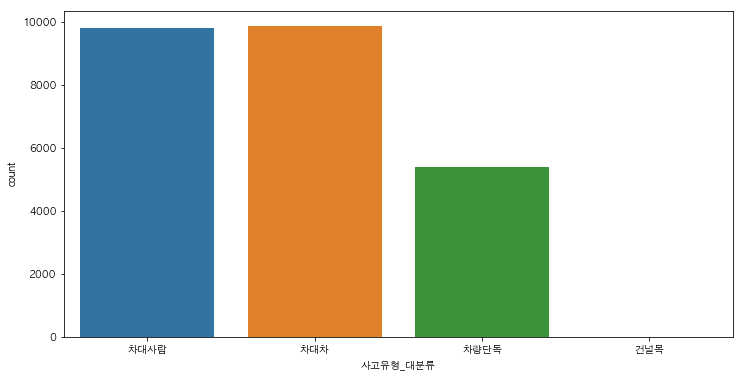

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.countplot(data=train, x="사고유형_대분류")

In [41]:
train["사고유형_대분류_차대차"] = train["사고유형_대분류"] == "차대차"
train["사고유형_대분류_차대사람"] = train["사고유형_대분류"] == "차대사람"
train["사고유형_대분류_차량단독"] = train["사고유형_대분류"] == "차량단독"

test["사고유형_대분류_차대차"] = test["사고유형_대분류"] == "차대차"
test["사고유형_대분류_차대사람"] = test["사고유형_대분류"] == "차대사람"
test["사고유형_대분류_차량단독"] = test["사고유형_대분류"] == "차량단독"

In [42]:
train["사고유형_중분류_추돌"] = train["사고유형_중분류"] == "추돌"
train["사고유형_중분류_측면충돌"] = train["사고유형_중분류"] == "측면충돌"
train["사고유형_중분류_기타"] = train["사고유형_중분류"] == "기타"
train["사고유형_중분류_공작물충돌"] = train["사고유형_중분류"] == "공작물충돌"

test["사고유형_중분류_추돌"] = test["사고유형_중분류"] == "추돌"
test["사고유형_중분류_측면충돌"] = test["사고유형_중분류"] == "측면충돌"
test["사고유형_중분류_기타"] = test["사고유형_중분류"] == "기타"
test["사고유형_중분류_공작물충돌"] = test["사고유형_중분류"] == "공작물충돌"

In [43]:
train["법규위반_안전운전 의무 불이행"] = train["법규위반"] == "안전운전 의무 불이행"
train["법규위반_신호위반"] = train["법규위반"] == "신호위반"
train["법규위반_보행자 보호의무 위반"] = train["법규위반"] == "보행자 보호의무 위반"
train["법규위반_과속"] = train["법규위반"] == "과속"

test["법규위반_안전운전 의무 불이행"] = test["법규위반"] == "안전운전 의무 불이행"
test["법규위반_신호위반"] = test["법규위반"] == "신호위반"
test["법규위반_보행자 보호의무 위반"] = test["법규위반"] == "보행자 보호의무 위반"
test["법규위반_과속"] = test["법규위반"] == "과속"

In [44]:
feature_names = ["사상자수", "사고유형_대분류_차대차", "사고유형_대분류_차대사람", "사고유형_대분류_차량단독", "사고유형_중분류_추돌", "사고유형_중분류_측면충돌", "사고유형_중분류_기타", "사고유형_중분류_공작물충돌", "법규위반_안전운전 의무 불이행", "법규위반_신호위반", "법규위반_보행자 보호의무 위반", "법규위반_과속"]
label_name = "당사자종별_2당_대분류"

In [45]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [46]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [47]:
predictions = model.predict(X_test)
test["result_당사자종별_2당_대분류"] = predictions
test.loc[test["당사자종별_2당_대분류"].isnull(), "당사자종별_2당_대분류"] = test["result_당사자종별_2당_대분류"]

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## fillin_당사자종별_1당_대분류

In [48]:
# feature colums : 사상자수, 사고유형_대분류, 사고유형_중분류, 법규위반, 당사자종별_2당_대분류

In [49]:
train["사고유형_대분류_차대차"] = train["사고유형_대분류"] == "차대차"
train["사고유형_대분류_차대사람"] = train["사고유형_대분류"] == "차대사람"
train["사고유형_대분류_차량단독"] = train["사고유형_대분류"] == "차량단독"

test["사고유형_대분류_차대차"] = test["사고유형_대분류"] == "차대차"
test["사고유형_대분류_차대사람"] = test["사고유형_대분류"] == "차대사람"
test["사고유형_대분류_차량단독"] = test["사고유형_대분류"] == "차량단독"

In [50]:
train["사고유형_중분류_추돌"] = train["사고유형_중분류"] == "추돌"
train["사고유형_중분류_측면충돌"] = train["사고유형_중분류"] == "측면충돌"
train["사고유형_중분류_기타"] = train["사고유형_중분류"] == "기타"
train["사고유형_중분류_공작물충돌"] = train["사고유형_중분류"] == "공작물충돌"

test["사고유형_중분류_추돌"] = test["사고유형_중분류"] == "추돌"
test["사고유형_중분류_측면충돌"] = test["사고유형_중분류"] == "측면충돌"
test["사고유형_중분류_기타"] = test["사고유형_중분류"] == "기타"
test["사고유형_중분류_공작물충돌"] = test["사고유형_중분류"] == "공작물충돌"

In [51]:
train["법규위반_안전운전 의무 불이행"] = train["법규위반"] == "안전운전 의무 불이행"
train["법규위반_신호위반"] = train["법규위반"] == "신호위반"
train["법규위반_보행자 보호의무 위반"] = train["법규위반"] == "보행자 보호의무 위반"
train["법규위반_과속"] = train["법규위반"] == "과속"
train["법규위반_부당한 회전"] = train["법규위반"] == "부당한 회전"

test["법규위반_안전운전 의무 불이행"] = test["법규위반"] == "안전운전 의무 불이행"
test["법규위반_신호위반"] = test["법규위반"] == "신호위반"
test["법규위반_보행자 보호의무 위반"] = test["법규위반"] == "보행자 보호의무 위반"
test["법규위반_과속"] = test["법규위반"] == "과속"
test["법규위반_부당한 회전"] = test["법규위반"] == "부당한 회전"

In [52]:
train["당사자종별_2당_대분류_승용차"] = train["당사자종별_2당_대분류"] == "승용차"
train["당사자종별_2당_대분류_화물차"] = train["당사자종별_2당_대분류"] == "화물차"
train["당사자종별_2당_대분류_보행자"] = train["당사자종별_2당_대분류"] == "보행자"
train["당사자종별_2당_대분류_없음"] = train["당사자종별_2당_대분류"] == "없음"

test["당사자종별_2당_대분류_승용차"] = test["당사자종별_2당_대분류"] == "승용차"
test["당사자종별_2당_대분류_화물차"] = test["당사자종별_2당_대분류"] == "화물차"
test["당사자종별_2당_대분류_보행자"] = test["당사자종별_2당_대분류"] == "보행자"
test["당사자종별_2당_대분류_없음"] = test["당사자종별_2당_대분류"] == "없음"

In [53]:
feature_names = ["사상자수", "사고유형_대분류_차대차", "사고유형_대분류_차대사람", "사고유형_대분류_차량단독", "사고유형_중분류_추돌", "사고유형_중분류_측면충돌", "사고유형_중분류_기타", "사고유형_중분류_공작물충돌", "법규위반_안전운전 의무 불이행", "법규위반_신호위반", "법규위반_보행자 보호의무 위반", "법규위반_과속", "법규위반_부당한 회전", "당사자종별_2당_대분류_승용차", "당사자종별_2당_대분류_화물차", "당사자종별_2당_대분류_보행자", "당사자종별_2당_대분류_없음"]
label_name = "당사자종별_1당_대분류"

In [54]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [55]:
feature_names

['사상자수',
 '사고유형_대분류_차대차',
 '사고유형_대분류_차대사람',
 '사고유형_대분류_차량단독',
 '사고유형_중분류_추돌',
 '사고유형_중분류_측면충돌',
 '사고유형_중분류_기타',
 '사고유형_중분류_공작물충돌',
 '법규위반_안전운전 의무 불이행',
 '법규위반_신호위반',
 '법규위반_보행자 보호의무 위반',
 '법규위반_과속',
 '법규위반_부당한 회전',
 '당사자종별_2당_대분류_승용차',
 '당사자종별_2당_대분류_화물차',
 '당사자종별_2당_대분류_보행자',
 '당사자종별_2당_대분류_없음']

In [56]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [57]:
predictions = model.predict(X_test)
test["result_당사자종별_1당_대분류"] = predictions
test.loc[test["당사자종별_1당_대분류"].isnull(), "당사자종별_1당_대분류"] = test["result_당사자종별_1당_대분류"]

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## fillin_법규위반

In [58]:
# feature columns : 도로형태, 당사자종별_1당_대분류, 당사자종별_2당_대분류

In [59]:
train["도로형태_교차로내"] = train["도로형태"] == "교차로내"
train["도로형태_기타단일로"] = train["도로형태"] == "기타단일로"
train["도로형태_교량위"] = train["도로형태"] == "교량위"
train["도로형태_교차로횡단보도내"] = train["도로형태"] == "교차로횡단보도내"

test["도로형태_교차로내"] = test["도로형태"] == "교차로내"
test["도로형태_기타단일로"] = test["도로형태"] == "기타단일로"
test["도로형태_교량위"] = test["도로형태"] == "교량위"
test["도로형태_교차로횡단보도내"] = test["도로형태"] == "교차로횡단보도내"

In [60]:
train["당사자종별_1당_대분류_이륜차"] = train["당사자종별_1당_대분류"] == "이륜차"
train["당사자종별_1당_대분류_원동기장치자전거"] = train["당사자종별_1당_대분류"] == "원동기장치자전거"
train["당사자종별_1당_대분류_승용차"] = train["당사자종별_1당_대분류"] == "승용차"
train["당사자종별_1당_대분류_화물차"] = train["당사자종별_1당_대분류"] == "화물차"
train["당사자종별_1당_대분류_승합차"] = train["당사자종별_1당_대분류"] == "승합차"
train["당사자종별_1당_대분류_특수차"] = train["당사자종별_1당_대분류"] == "특수차"

test["당사자종별_1당_대분류_이륜차"] = test["당사자종별_1당_대분류"] == "이륜차"
test["당사자종별_1당_대분류_원동기장치자전거"] = test["당사자종별_1당_대분류"] == "원동기장치자전거"
test["당사자종별_1당_대분류_승용차"] = test["당사자종별_1당_대분류"] == "승용차"
test["당사자종별_1당_대분류_화물차"] = test["당사자종별_1당_대분류"] == "화물차"
test["당사자종별_1당_대분류_승합차"] = test["당사자종별_1당_대분류"] == "승합차"
test["당사자종별_1당_대분류_특수차"] = test["당사자종별_1당_대분류"] == "특수차"

In [61]:
train["당사자종별_2당_대분류_승용차"] = train["당사자종별_2당_대분류"] == "승용차"
train["당사자종별_2당_대분류_화물차"] = train["당사자종별_2당_대분류"] == "화물차"
train["당사자종별_2당_대분류_승합차"] = train["당사자종별_2당_대분류"] == "승합차"
train["당사자종별_2당_대분류_보행자"] = train["당사자종별_2당_대분류"] == "보행자"
train["당사자종별_2당_대분류_없음"] = train["당사자종별_2당_대분류"] == "없음"

test["당사자종별_2당_대분류_승용차"] = test["당사자종별_2당_대분류"] == "승용차"
test["당사자종별_2당_대분류_화물차"] = test["당사자종별_2당_대분류"] == "화물차"
test["당사자종별_2당_대분류_승합차"] = test["당사자종별_2당_대분류"] == "승합차"
test["당사자종별_2당_대분류_보행자"] = test["당사자종별_2당_대분류"] == "보행자"
test["당사자종별_2당_대분류_없음"] = test["당사자종별_2당_대분류"] == "없음"

In [62]:
feature_names = ["도로형태_교차로내", "도로형태_기타단일로", "도로형태_교량위", "도로형태_교차로횡단보도내", "당사자종별_1당_대분류_이륜차", "당사자종별_1당_대분류_원동기장치자전거", "당사자종별_1당_대분류_승용차", "당사자종별_1당_대분류_화물차",  "당사자종별_1당_대분류_승합차", "당사자종별_1당_대분류_특수차", "당사자종별_2당_대분류_보행자", "당사자종별_2당_대분류_없음", "당사자종별_2당_대분류_승용차", "당사자종별_2당_대분류_화물차", "당사자종별_2당_대분류_승합차"]
label_name = "법규위반"

In [63]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [64]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [65]:
predictions = model.predict(X_test)
test["result_법규위반"] = predictions
test.loc[test["법규위반"].isnull(), "법규위반"] = test["result_법규위반"]

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## fillin_사고유형_중분류

In [66]:
# feature columns : 도로형태, 당사자종별_1당_대분류, 당사자종별_2당_대분류

In [67]:
train_측면충돌 = train.loc[train["사고유형_중분류"] == "측면충돌"]
train_측면직각충돌 = train.loc[train["사고유형_중분류"] == "측면직각충돌"]

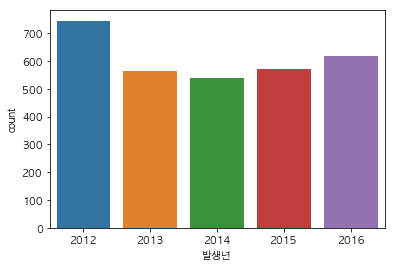

In [68]:
sns.countplot(data=train_측면직각충돌, x="발생년")

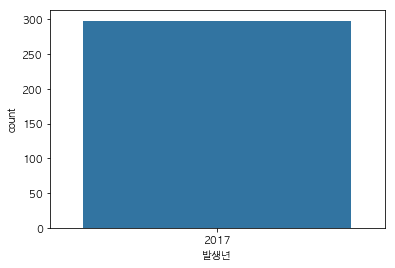

In [69]:
sns.countplot(data=train_측면충돌, x="발생년")

In [70]:
train["도로형태_교차로내"] = train["도로형태"] == "교차로내"
train["도로형태_기타단일로"] = train["도로형태"] == "기타단일로"
train["도로형태_교량위"] = train["도로형태"] == "교량위"
train["도로형태_교차로횡단보도내"] = train["도로형태"] == "교차로횡단보도내"

test["도로형태_교차로내"] = test["도로형태"] == "교차로내"
test["도로형태_기타단일로"] = test["도로형태"] == "기타단일로"
test["도로형태_교량위"] = test["도로형태"] == "교량위"
test["도로형태_교차로횡단보도내"] = test["도로형태"] == "교차로횡단보도내"

In [71]:
train["당사자종별_1당_대분류_이륜차"] = train["당사자종별_1당_대분류"] == "이륜차"
train["당사자종별_1당_대분류_원동기장치자전거"] = train["당사자종별_1당_대분류"] == "원동기장치자전거"
train["당사자종별_1당_대분류_승용차"] = train["당사자종별_1당_대분류"] == "승용차"
train["당사자종별_1당_대분류_화물차"] = train["당사자종별_1당_대분류"] == "화물차"
train["당사자종별_1당_대분류_승합차"] = train["당사자종별_1당_대분류"] == "승합차"
train["당사자종별_1당_대분류_특수차"] = train["당사자종별_1당_대분류"] == "특수차"

test["당사자종별_1당_대분류_이륜차"] = test["당사자종별_1당_대분류"] == "이륜차"
test["당사자종별_1당_대분류_원동기장치자전거"] = test["당사자종별_1당_대분류"] == "원동기장치자전거"
test["당사자종별_1당_대분류_승용차"] = test["당사자종별_1당_대분류"] == "승용차"
test["당사자종별_1당_대분류_화물차"] = test["당사자종별_1당_대분류"] == "화물차"
test["당사자종별_1당_대분류_승합차"] = test["당사자종별_1당_대분류"] == "승합차"
test["당사자종별_1당_대분류_특수차"] = test["당사자종별_1당_대분류"] == "특수차"

In [72]:
train["당사자종별_2당_대분류_승용차"] = train["당사자종별_2당_대분류"] == "승용차"
train["당사자종별_2당_대분류_화물차"] = train["당사자종별_2당_대분류"] == "화물차"
train["당사자종별_2당_대분류_승합차"] = train["당사자종별_2당_대분류"] == "승합차"
train["당사자종별_2당_대분류_보행자"] = train["당사자종별_2당_대분류"] == "보행자"
train["당사자종별_2당_대분류_없음"] = train["당사자종별_2당_대분류"] == "없음"

test["당사자종별_2당_대분류_승용차"] = test["당사자종별_2당_대분류"] == "승용차"
test["당사자종별_2당_대분류_화물차"] = test["당사자종별_2당_대분류"] == "화물차"
test["당사자종별_2당_대분류_승합차"] = test["당사자종별_2당_대분류"] == "승합차"
test["당사자종별_2당_대분류_보행자"] = test["당사자종별_2당_대분류"] == "보행자"
test["당사자종별_2당_대분류_없음"] = test["당사자종별_2당_대분류"] == "없음"

In [73]:
feature_names = ["도로형태_교차로내", "도로형태_기타단일로", "도로형태_교량위", "도로형태_교차로횡단보도내", "당사자종별_2당_대분류_보행자", "당사자종별_2당_대분류_없음", "당사자종별_2당_대분류_승용차", "당사자종별_2당_대분류_화물차", "당사자종별_2당_대분류_승합차"]
label_name = "사고유형_중분류"

In [74]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [75]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [76]:
predictions = model.predict(X_test)
test["result_사고유형_중분류"] = predictions
test.loc[test["사고유형_중분류"].isnull(), "사고유형_중분류"] = test["result_사고유형_중분류"]
test.loc[test["사고유형_중분류"] == "측면직각충돌", "사고유형_중분류"] = "측면충돌"

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## fillin_주야

In [77]:
# feature columns : 요일, 도로형태, 법규위반, 사고유형_중분류, 당사자종별_1당_대분류, 당사자종별_2당_대분류

In [143]:
train["요일_화"] = train["요일"] == "화"
train["요일_목"] = train["요일"] == "목"
train["요일_일"] = train["요일"] == "일"

test["요일_화"] = test["요일"] == "화"
test["요일_목"] = test["요일"] == "목"
test["요일_일"] = test["요일"] == "일"

In [144]:
train["도로형태_교차로내"] = train["도로형태"] == "교차로내"
train["도로형태_기타단일로"] = train["도로형태"] == "기타단일로"

test["도로형태_교차로내"] = test["도로형태"] == "교차로내"
test["도로형태_기타단일로"] = test["도로형태"] == "기타단일로"

In [145]:
train["법규위반_안전운전 의무 불이행"] = train["법규위반"] == "안전운전 의무 불이행"
train["법규위반_신호위반"] = train["법규위반"] == "신호위반"
train["법규위반_부당한 회전"] = train["법규위반"] == "부당한 회전"

test["법규위반_안전운전 의무 불이행"] = test["법규위반"] == "안전운전 의무 불이행"
test["법규위반_신호위반"] = test["법규위반"] == "신호위반"
test["법규위반_부당한 회전"] = test["법규위반"] == "부당한 회전"

In [146]:
train["사고유형_중분류_추돌"] = train["사고유형_중분류"] == "추돌"
train["사고유형_중분류_측면충돌"] = train["사고유형_중분류"] == "측면충돌"
train["사고유형_중분류_기타"] = train["사고유형_중분류"] == "기타"

test["사고유형_중분류_추돌"] = test["사고유형_중분류"] == "추돌"
test["사고유형_중분류_측면충돌"] = test["사고유형_중분류"] == "측면충돌"
test["사고유형_중분류_기타"] = test["사고유형_중분류"] == "기타"

In [147]:
train["당사자종별_1당_대분류_이륜차"] = train["당사자종별_1당_대분류"] == "이륜차"
train["당사자종별_1당_대분류_자전거"] = train["당사자종별_1당_대분류"] == "자전거"
train["당사자종별_1당_대분류_승용차"] = train["당사자종별_1당_대분류"] == "승용차"
train["당사자종별_1당_대분류_승합차"] = train["당사자종별_1당_대분류"] == "승합차"

test["당사자종별_1당_대분류_이륜차"] = test["당사자종별_1당_대분류"] == "이륜차"
test["당사자종별_1당_대분류_자전거"] = test["당사자종별_1당_대분류"] == "자전거"
test["당사자종별_1당_대분류_승용차"] = test["당사자종별_1당_대분류"] == "승용차"
test["당사자종별_1당_대분류_승합차"] = test["당사자종별_1당_대분류"] == "승합차"

In [148]:
train["당사자종별_2당_대분류_승용차"] = train["당사자종별_2당_대분류"] == "승용차"
train["당사자종별_2당_대분류_보행자"] = train["당사자종별_2당_대분류"] == "보행자"
train["당사자종별_2당_대분류_원동기장치자전거"] = train["당사자종별_2당_대분류"] == "원동기장치자전거"

test["당사자종별_2당_대분류_승용차"] = test["당사자종별_2당_대분류"] == "승용차"
test["당사자종별_2당_대분류_보행자"] = test["당사자종별_2당_대분류"] == "보행자"
test["당사자종별_2당_대분류_원동기장치자전거"] = test["당사자종별_2당_대분류"] == "원동기장치자전거"

In [149]:
feature_names = ["요일_화","요일_목", "요일_일", "도로형태_교차로내", "도로형태_기타단일로", "법규위반_안전운전 의무 불이행", "법규위반_신호위반", "법규위반_부당한 회전", "사고유형_중분류_추돌", "사고유형_중분류_측면충돌", "사고유형_중분류_기타", "당사자종별_1당_대분류_이륜차", "당사자종별_1당_대분류_자전거", "당사자종별_1당_대분류_승용차", "당사자종별_1당_대분류_승합차", "당사자종별_2당_대분류_보행자", "당사자종별_2당_대분류_승용차", "당사자종별_2당_대분류_원동기장치자전거"]
label_name = "주야"

In [150]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [151]:
model = RandomForestClassifier()

In [152]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [154]:
predictions = model.predict(X_test)
test["result_주야"] = predictions
test.loc[test["주야"].isnull(), "주야"] = test["result_주야"]

## fillin_요일

In [ ]:
# feature columns : 주야, 도로형태, 법규위반, 사고유형_중분류, 당사자종별_1당_대분류, 당사자종별_2당_대분류

In [335]:
train["주야_주간"] = train["주야"] == "주간"
train["주야_야간"] = train["주야"] == "야간"

test["주야_주간"] = test["주야"] == "주간"
test["주야_야간"] = test["주야"] == "야간"

In [336]:
train["도로형태_교차로내"] = train["도로형태"] == "교차로내"
train["도로형태_기타단일로"] = train["도로형태"] == "기타단일로"

test["도로형태_교차로내"] = test["도로형태"] == "교차로내"
test["도로형태_기타단일로"] = test["도로형태"] == "기타단일로"

In [337]:
train["법규위반_안전운전 의무 불이행"] = train["법규위반"] == "안전운전 의무 불이행"
train["법규위반_신호위반"] = train["법규위반"] == "신호위반"

test["법규위반_안전운전 의무 불이행"] = test["법규위반"] == "안전운전 의무 불이행"
test["법규위반_신호위반"] = test["법규위반"] == "신호위반"

In [338]:
train["사고유형_대분류_차대차"] = train["사고유형_대분류"] == "차대차"
train["사고유형_대분류_차대사람"] = train["사고유형_대분류"] == "차대사람"
train["사고유형_대분류_차량단독"] = train["사고유형_대분류"] == "차량단독"

test["사고유형_대분류_차대차"] = test["사고유형_대분류"] == "차대차"
test["사고유형_대분류_차대사람"] = test["사고유형_대분류"] == "차대사람"
test["사고유형_대분류_차량단독"] = test["사고유형_대분류"] == "차량단독"

In [339]:
train["사고유형_중분류_정면충돌"] = train["사고유형_중분류"] == "정면충돌"
train["사고유형_중분류_측면충돌"] = train["사고유형_중분류"] == "측면충돌"
train["사고유형_중분류_공작물충돌"] = train["사고유형_중분류"] == "공작물충돌"
train["사고유형_중분류_길가장자리구역통행중"] = train["사고유형_중분류"] == "길가장자리구역통행중"

test["사고유형_중분류_정면충돌"] = test["사고유형_중분류"] == "정면충돌"
test["사고유형_중분류_측면충돌"] = test["사고유형_중분류"] == "측면충돌"
test["사고유형_중분류_공작물충돌"] = test["사고유형_중분류"] == "공작물충돌"
test["사고유형_중분류_길가장자리구역통행중"] = test["사고유형_중분류"] == "길가장자리구역통행중"

In [340]:
train["당사자종별_1당_대분류_이륜차"] = train["당사자종별_1당_대분류"] == "이륜차"
train["당사자종별_1당_대분류_자전거"] = train["당사자종별_1당_대분류"] == "자전거"
train["당사자종별_1당_대분류_승용차"] = train["당사자종별_1당_대분류"] == "승용차"
train["당사자종별_1당_대분류_승합차"] = train["당사자종별_1당_대분류"] == "승합차"
train["당사자종별_1당_대분류_화물차"] = train["당사자종별_1당_대분류"] == "화물차"

test["당사자종별_1당_대분류_이륜차"] = test["당사자종별_1당_대분류"] == "이륜차"
test["당사자종별_1당_대분류_자전거"] = test["당사자종별_1당_대분류"] == "자전거"
test["당사자종별_1당_대분류_승용차"] = test["당사자종별_1당_대분류"] == "승용차"
test["당사자종별_1당_대분류_승합차"] = test["당사자종별_1당_대분류"] == "승합차"
test["당사자종별_1당_대분류_화물차"] = test["당사자종별_1당_대분류"] == "화물차"

In [341]:
train["당사자종별_2당_대분류_승용차"] = train["당사자종별_2당_대분류"] == "승용차"
train["당사자종별_2당_대분류_보행자"] = train["당사자종별_2당_대분류"] == "보행자"
train["당사자종별_2당_대분류_원동기장치자전거"] = train["당사자종별_2당_대분류"] == "원동기장치자전거"

test["당사자종별_2당_대분류_승용차"] = test["당사자종별_2당_대분류"] == "승용차"
test["당사자종별_2당_대분류_보행자"] = test["당사자종별_2당_대분류"] == "보행자"
test["당사자종별_2당_대분류_원동기장치자전거"] = test["당사자종별_2당_대분류"] == "원동기장치자전거"

In [416]:
feature_names = ["주야_주간", "주야_야간", "법규위반_안전운전 의무 불이행", "법규위반_신호위반", "사고유형_중분류_정면충돌", "사고유형_중분류_측면충돌", "사고유형_중분류_공작물충돌", "사고유형_중분류_길가장자리구역통행중", "당사자종별_1당_대분류_이륜차", "당사자종별_1당_대분류_자전거", "당사자종별_1당_대분류_승용차", "당사자종별_1당_대분류_승합차", "당사자종별_1당_대분류_화물차", "당사자종별_2당_대분류_승용차", "당사자종별_2당_대분류_보행자", "당사자종별_2당_대분류_원동기장치자전거", "사고유형_대분류_차대차", "사고유형_대분류_차대사람", "사고유형_대분류_차량단독"]
label_name = "요일"

In [417]:
X_train = train[feature_names]
y_train = train[label_name]
X_test = test[feature_names]

In [418]:
model = xgb.XGBClassifier()

In [419]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [425]:
predictions = model.predict(X_test)
test["result_요일"] = predictions
test.loc[test["요일"].isnull(), "요일"] = test["result_요일"]

/Users/PJS/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## fillin_발생지시도